In [1]:
from tensorflow.python.client import device_lib 
import tensorflow as tf 
import os

os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # gpu idx

with tf.device('/device:GPU:1'):
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11284915936246339391
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14286848000
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15586594223718701788
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy import io
import numpy as np
import itertools
import pathlib
import cv2
import os

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

EPOCH = 100
KERNEL_SIZE = 3
BATCH_SIZE = 10
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

DATA_PATH = "./graph_data/"

def list_to_list(input_list):
    input_list_to_list = list(itertools.chain(*input_list))
    return input_list_to_list

def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [3]:
data_dir = pathlib.Path(DATA_PATH)
print(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

f = list(data_dir.glob('F/*'))
n = list(data_dir.glob('N/*'))
q = list(data_dir.glob('Q/*'))
s = list(data_dir.glob('S/*'))
v = list(data_dir.glob('V/*'))

graph_data
112599


In [4]:
parents_path = DATA_PATH
child_path = os.listdir(parents_path)

npy_check_list = []

temp_converted_img = list()
temp_ann_list = list()
X = list()
y = list()

for pic_path in (child_path):
    current_path = os.listdir(parents_path + pic_path)
    print("[INFO] Current path : " + parents_path + pic_path)
    for file_name in tqdm(current_path):
        path_for_array = parents_path + pic_path + "/" + file_name

        img = cv2.imread(path_for_array)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resize = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_AREA)
        temp_converted_img.append(img_resize / 255.0)
        
        check_ann = pic_path
        
        if check_ann == "N":            # Normal
            temp_ann_list.append([1, 0, 0, 0, 0])
        
        elif check_ann == "S":          # Supra-ventricular
            temp_ann_list.append([0, 1, 0, 0, 0])
        
        elif check_ann == "V":          # Ventricular
            temp_ann_list.append([0, 0, 1, 0, 0])
        
        elif check_ann == "F":          # False alarm
            temp_ann_list.append([0, 0, 0, 1, 0])
        
        else:                           # Unclassed 
            temp_ann_list.append([0, 0, 0, 0, 1])
    
        y.append(temp_ann_list)

[INFO] Current path : ./graph_data/F


100%|██████████| 803/803 [00:05<00:00, 134.27it/s]


[INFO] Current path : ./graph_data/N


100%|██████████| 90631/90631 [10:35<00:00, 142.62it/s]


[INFO] Current path : ./graph_data/Q


100%|██████████| 11148/11148 [01:18<00:00, 141.30it/s]


[INFO] Current path : ./graph_data/S


100%|██████████| 2781/2781 [00:21<00:00, 130.88it/s]


[INFO] Current path : ./graph_data/V


100%|██████████| 7236/7236 [00:56<00:00, 127.26it/s]


In [5]:
onehot_y = np.array(temp_ann_list)
temp_converted_img = np.array(temp_converted_img)

X_train, X_test, y_train, y_test = train_test_split(temp_converted_img, onehot_y, test_size=0.33, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42, shuffle=True)

print("[SIZE]\t\tX_train lenght : {}\n\t\ty_train length : {}".format(X_train.shape, y_train.shape))
print("[SIZE]\t\tX_validation length : {}\n\t\ty_validation length : {}".format(X_val.shape, y_val.shape))
print("[SIZE]\t\tX_test length : {}\n\t\ty_test length : {}".format(X_test.shape, y_test.shape))

[SIZE]		X_train lenght : (75441, 128, 128)
		y_train length : (75441, 5)
[SIZE]		X_validation length : (12263, 128, 128)
		y_validation length : (12263, 5)
[SIZE]		X_test length : (24895, 128, 128)
		y_test length : (24895, 5)


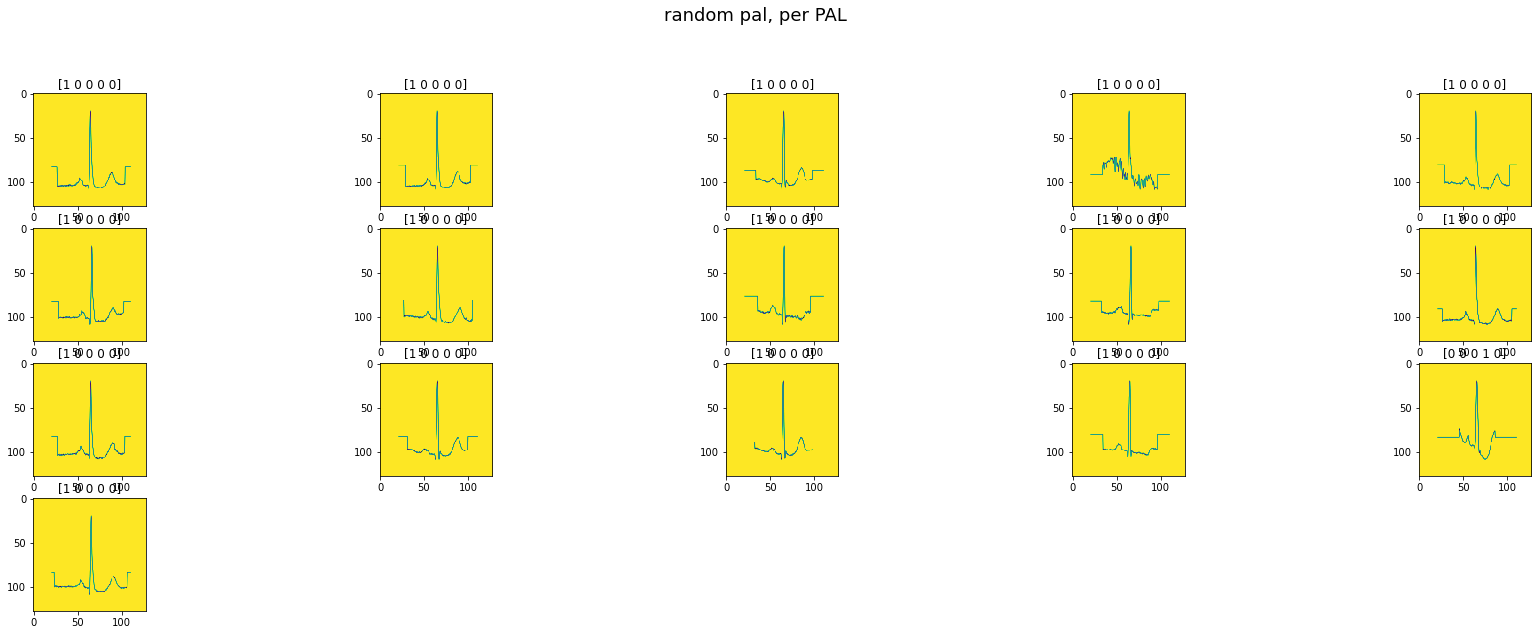

In [6]:
# 랜덤으로 뽑아서 뿌려보기

import matplotlib.pyplot as plt
import random
%matplotlib inline

plt.figure(figsize=(30, 12))
plt.suptitle("random pal, per PAL", fontsize=18)
n = 0
random.seed(11)
for i in random.sample(range(6480), 16):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(temp_converted_img[i] * 255.0, interpolation='nearest')
    ax.set_title(str(onehot_y[i]))
    n+=1

# 대망의 덴스-넷

In [7]:
# hyperparameter
growth_k = 32
nb_block = 2
init_learning_rate = 1e-4
epsilon = 1e-8
DROPOUT_RATE = 0.2

# momentum optimizer
nesterov_momentum = 0.9
weight_decay = 1e-4

#Label, batch_size
calss_num = 5
batch_size = 50

total_epochs = 100

In [8]:

# bottleneck
def bottleneck_layer(inputs, growth_k=32):
    x = layers.BatchNormalization()(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(4 * growth_k, kernel_size=(1, 1))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
        
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(growth_k, kernel_size=(3, 3), padding='same')(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
        
    return x

# transition
def transition_layer(inputs, growth_k=32):
    x = layers.BatchNormalization()(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(growth_k, kernel_size=(1, 1))(x)
    
    in_channel = x.shape[-1]
    
    x = layers.Conv2D(in_channel * 0.5, kernel_size=(1, 1))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='same')(x)
    
    return x

# dense_block
def dense_block(inputs, nb_layers):
    layers_concat=[]
    layers_concat.append(inputs)
    
    x = bottleneck_layer(inputs)
    
    layers_concat.append(x)
    
    for i in range(nb_layers - 1):
        x = layers.Concatenate(axis=3)(layers_concat)
        x = bottleneck_layer(x)
        layers_concat.append(x)
    
    x = layers.Concatenate(axis=3)(layers_concat)
    
    return x

# classification_layer
def classify_layer(inputs):
    x = layers.BatchNormalization()(inputs)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    output_layer = layers.Dense(5, activation='softmax')(x)
    
    return output_layer

# input_layer 정의
input_layer = layers.Input(shape=(128, 128, 1))

# DenseNet 완성!
def Dense_net():
    growth_k = 32
    x = layers.Conv2D(2*growth_k, kernel_size=(7, 7), strides=2)(input_layer)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    
    for i in range(nb_block):
        x = dense_block(x, 6)
        x = transition_layer(x)
        x = dense_block(x, 12)
        x = transition_layer(x)  
        x = dense_block(x, 64)
        x = transition_layer(x)
        
    x = dense_block(inputs=x, nb_layers=32)
    output_layer = classify_layer(x)
    
    return output_layer

In [9]:
denseNet = tf.keras.models.Model(input_layer, Dense_net())

In [10]:
# denseNet.summary()

In [11]:
# from tensorflow.keras.utils import plot_model

# plot_model(denseNet, to_file='model.png')
# plot_model(denseNet, to_file='model_shape.png', show_shapes=True)

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
denseNet.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [13]:
callbacks = [ModelCheckpoint(filepath = "./checkpoint/denseNet/",
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             save_weights_only = False,
                             mode = 'max',
                             verbose = 1)]
                             
with tf.device('/device:GPU:0'):
    history = denseNet.fit(X_train, y_train,
                        batch_size = BATCH_SIZE,
                        epochs = EPOCH,
                        verbose = 1,
                        callbacks = callbacks,
                        validation_data = (X_val, y_val))

Epoch 1/100
7545/7545 [==============================] - ETA: 0s - loss: 0.7428 - accuracy: 0.7988
Epoch 1: val_accuracy improved from -inf to 0.80616, saving model to ./checkpoint/denseNet\


INFO:tensorflow:Assets written to: ./checkpoint/denseNet\assets


INFO:tensorflow:Assets written to: ./checkpoint/denseNet\assets


7545/7545 [==============================] - 3092s 402ms/step - loss: 0.7428 - accuracy: 0.7988 - val_loss: nan - val_accuracy: 0.8062
Epoch 2/100
7545/7545 [==============================] - ETA: 0s - loss: 0.6678 - accuracy: 0.8059
Epoch 2: val_accuracy did not improve from 0.80616
7545/7545 [==============================] - 2717s 360ms/step - loss: 0.6678 - accuracy: 0.8059 - val_loss: nan - val_accuracy: 0.8062
Epoch 3/100
7545/7545 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.8079
Epoch 3: val_accuracy did not improve from 0.80616
7545/7545 [==============================] - 2723s 361ms/step - loss: 0.6357 - accuracy: 0.8079 - val_loss: nan - val_accuracy: 0.8062
Epoch 4/100
7545/7545 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.8475
Epoch 4: val_accuracy did not improve from 0.80616
7545/7545 [==============================] - 2659s 352ms/step - loss: 0.4790 - accuracy: 0.8475 - val_loss: nan - val_accuracy: 0.8062
Epoch 5/10

: 

: 

In [ ]:

Y_pred = denseNet.predict(X_val)
Y_true = np.argmax(y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


plt.figure(figsize=(15,5), facecolor = 'white')
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accurcay')
plt.legend(['train', 'test'])

plt.subplot(122)
plt.title("Loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
score = denseNet.evaluate(X_val, y_val, verbose = 0)

print('Test loss:', round(score[0], 3))
print('Test accuracy:', round(score[1], 3))
print(classification_report(Y_true, Y_pred))

x_lab = ['N','Q','S','V','F']
y_lab = ['N','Q','S','V','F']

conf_matrix = confusion_matrix(Y_true, Y_pred)
conf_matrix_f = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14,5), facecolor='white')
plt.subplot(121)
plt.title("Confusion Matrix: num")
aa = sns.heatmap(conf_matrix,
                 xticklabels = x_lab,
                 yticklabels = y_lab,
                 annot=True,
                 fmt=".0f",
                 cmap=plt.cm.binary,
                facecolor='white')

In [ ]:
plt.yticks(rotation='horizontal')
plt.ylabel('True')
plt.xlabel('Predict')
plt.subplot(122)
plt.title("Confusion Matrix: ratio")

aa = sns.heatmap(conf_matrix_f,
                 xticklabels = x_lab,
                 yticklabels = y_lab,
                 annot=True,
                 fmt=".3f",
                 cmap=plt.cm.binary,
                facecolor='white')

plt.yticks(rotation='horizontal')
plt.ylabel('True')
plt.xlabel('Predict')
plt.tight_layout()